In [1]:
# Importing the required libraries

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

/usr/lib/python3/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1.0 Data Preprocessing

In [2]:
# The score has been turned into binary class- Positive and Negative

con = sqlite3.connect(r"final.sqlite")
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con)
filtered_data.shape

(364171, 11)

In [3]:
# Taking first 100,000 points for analysis

filtered_data = filtered_data.sort_values(by=['Time'])
final = filtered_data[0:100000]
final.Score.value_counts()

Positive    87729
Negative    12271
Name: Score, dtype: int64

In [4]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        #print(i)
        #print(sent)
        break;
    i += 1;    

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

stop = set(stopwords.words('english')) #set of stopwords
sno = SnowballStemmer('english') #initialising the snowball stemmer

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kushalkul01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [6]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [7]:
final = final.sort_values(by=['Time']) #Just to be double sure that dataframe is sorted according to time

# Taking labels to make y-dimension
labels=final['Score'].values

# Checking the shape of labels
print("Shape of y-vector is",labels.shape)

Shape of y-vector is (100000,)


In [8]:
# Taking initial 70% data as training data and remaining 30% as test data

l = 0.7 * final.shape[0]
X_train = final['CleanedText'][0:int(l)]
X_test = final['CleanedText'][int(l):]
y_train = labels[0:int(l)]
y_test = labels[int(l):]

#### Bag of Words (To get average Word2Vec)

In [9]:
# Making the bag of words model
# Fitting the model on Training data and transforming the test data on the fitted model
# This helps in taking care of data leakage

from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)
y_train_bow = y_train
y_test_bow = y_test
print("The type of count vectorizer ",type(X_train_bow))
print("the shape of out text TFIDF vectorizer ",X_train_bow.get_shape())
print("the number of unique words", X_train_bow.get_shape()[1])

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (70000, 31375)
the number of unique words 31375


#### TF-IDF (To get weighted Word2Vec)

In [10]:
# importing the right libraries

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


# making tf-idf vector

tf_idf_vect = TfidfVectorizer() # using ngram_range as (1,1) due to computation restrictions
X_train_tf = tf_idf_vect.fit_transform(X_train)
X_test_tf = tf_idf_vect.transform(X_test)
y_train_tf = y_train
y_test_tf = y_test


# checking the properties of tf-idf vector

print("the type of count vectorizer ",type(X_train_tf))
print("the shape of out text TFIDF vectorizer ",X_train_tf.get_shape())
print("the number of unique words", X_train_tf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (70000, 31375)
the number of unique words 31375


# 4.0 Word2Vec

In [11]:
import gensim
from gensim.models import Word2Vec

In [12]:
i=0
list_of_sent=[]
for sent in X_train:
    list_of_sent.append(sent.split())
    
list_of_sent_tst=[]
for sent in X_test:
    list_of_sent_tst.append(sent.split())

In [13]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
count_vect_feat = bow.get_feature_names() # list of words in the BoW
print(count_vect_feat[count_vect_feat.index('like')])

like


### 4.1 Average Word2Vec

In [14]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
50


In [15]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list

for sent in list_of_sent_tst: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


In [16]:
X_train_avg = sent_vectors
X_test_avg = sent_vectors_test
y_train_avg = y_train
y_test_avg = y_test

print("Length of X_train :",len(X_train_avg))
print("Length of X_test :",len(X_test_avg))

Length of X_train : 70000
Length of X_test : 30000


In [17]:
# Converting 'Positive' and 'Negative' into True and False

y_train_avg = y_train_avg == 'Positive'
y_test_avg = y_test_avg == 'Positive'

In [ ]:
# Applying Decision Tree

depth = list(range(2,10))
cv_scores_avg = []
MSE = []
for i in depth:
    tree_avg=DecisionTreeClassifier(max_depth = i)
    scores = cross_val_score(tree_avg, X_train_avg, y_train_avg, cv=3, scoring='f1', n_jobs=-1)
    cv_scores_avg.append(scores.mean())
    tree_avg.fit(X_train_avg, y_train_avg)
    y_pred = tree_avg.predict(X_test_avg)
    error = mean_squared_error(y_test_avg.astype(np.float32) , y_pred.astype(np.float32))
    MSE.append(error)

In [19]:
# determining best depth

optimal_depth = depth[MSE.index(min(MSE))]
print('The optimal number of neighbors is %d.' % optimal_depth)
print("Maximum score for average model is {:.2f} %.".format(max(cv_scores_avg) * 100))

The optimal number of neighbors is 6.
Maximum score for average model is 93.94 %.


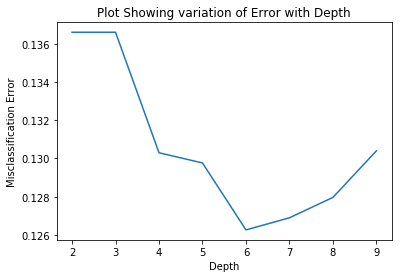

In [20]:
# Plot - Depth vs MSE

plt.plot(depth , MSE)
plt.xlabel("Depth")
plt.ylabel("Misclassification Error")
plt.title("Plot Showing variation of Error with Depth")
plt.show()

In [21]:
# Fitting Decision Tree with optimal Depth

classifier = DecisionTreeClassifier(max_depth = optimal_depth)
classifier.fit(X_train_avg , y_train_avg)

# predicting the values and taking accuracy score

y_pred_avg = classifier.predict(X_test_avg)
accuracy_avg = accuracy_score(y_pred_avg,y_test_avg)
print("Accuracy score for Average-Word2Vec model on test data is {:.2f} %.".format(accuracy_avg * 100))

Accuracy score for Average-Word2Vec model on test data is 87.37 %.


Confusion Matrix:


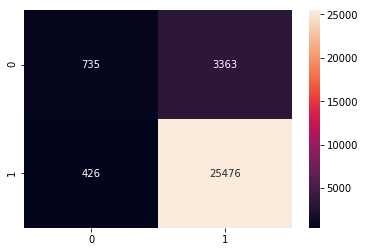

TPR for the model on test data is 0.98
FPR for the model on test data is 0.82
TNR for the model on test data is 0.18
FNR for the model on test data is 0.02



In [22]:
from sklearn.metrics import confusion_matrix
cm_avg = confusion_matrix(y_test_avg , y_pred_avg)
print("Confusion Matrix:")
sns.heatmap(cm_avg, annot=True, fmt='d')
plt.show()

# calculating TPR, FPR, TNR, FNR

tn, fp, fn, tp = cm_avg.ravel()

tnr_tf = tn/(tn+fp)
fpr_tf = fp/(tn+fp)
fnr_tf = fn/(fn+tp)
tpr_tf = tp/(fn+tp)

print("TPR for the model on test data is {:.2f}".format(tpr_tf))
print("FPR for the model on test data is {:.2f}".format(fpr_tf))
print("TNR for the model on test data is {:.2f}".format(tnr_tf))
print("FNR for the model on test data is {:.2f}\n".format(fnr_tf))

In [23]:
# calculating accuracy, precision and recall 

accuracy_avg = accuracy_score(y_test_avg , y_pred_avg)
precision_avg = precision_score(y_test_avg , y_pred_avg)
recall_avg = recall_score(y_test_avg , y_pred_avg)
f1_avg = f1_score(y_test_avg , y_pred_avg)

print("Accuracy score for the model on test data is {:.2f}".format(accuracy_avg))
print("Precision score for the model on test data is {:.2f}".format(precision_avg))
print("Recall score for the model on test data is {:.2f}".format(recall_avg))
print("F1 score for the model on test data is {:.2f}\n".format(f1_avg))

Accuracy score for the model on test data is 0.87
Precision score for the model on test data is 0.88
Recall score for the model on test data is 0.98
F1 score for the model on test data is 0.93



### 4.2 TF-IDF Weighted Word2Vec

In [24]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_tf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

70000
50


In [25]:
tfidf_sent_vectors_tst=[]
row=0
for sent in list_of_sent_tst: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_tf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tst.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors_tst))
print(len(tfidf_sent_vectors_tst[0]))

30000
50


In [26]:
X_train_w2v = tfidf_sent_vectors
X_test_w2v = tfidf_sent_vectors_tst
y_train_w2v = y_train
y_test_w2v = y_test

print("Length of X_train :",len(X_train_w2v))
print("Length of X_test :",len(X_test_w2v))

Length of X_train : 70000
Length of X_test : 30000


In [27]:
# Converting 'Positive' and 'Negative' into True and False

y_train_w2v = y_train_w2v == 'Positive'
y_test_w2v = y_test_w2v == 'Positive'

In [30]:
# Applying Decision Tree

depth = list(range(2,10))
cv_scores_w2v = []
MSE = []
for i in depth:
    tree_avg=DecisionTreeClassifier(max_depth = i)
    scores = cross_val_score(tree_avg, X_train_w2v, y_train_w2v, cv=3, scoring='f1', n_jobs=-1)
    cv_scores_w2v.append(scores.mean())
    tree_avg.fit(X_train_w2v, y_train_w2v)
    y_pred = tree_avg.predict(X_test_w2v)
    error = mean_squared_error(y_test_w2v.astype(np.float32) , y_pred.astype(np.float32))
    MSE.append(error)

In [31]:
# determining best depth
optimal_depth = depth[MSE.index(min(MSE))]
print('The optimal number of neighbors is %d.' % optimal_depth)
print("Maximum score for average model is {:.2f} %.".format(max(cv_scores_w2v) * 100))

The optimal number of neighbors is 7.
Maximum score for average model is 93.84 %.


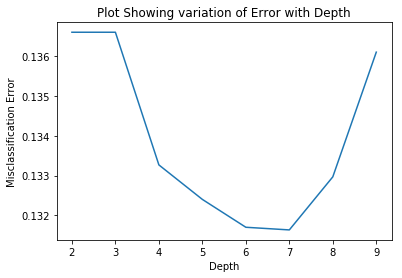

In [32]:
# Plot - Depth vs MSE

plt.plot(depth , MSE)
plt.xlabel("Depth")
plt.ylabel("Misclassification Error")
plt.title("Plot Showing variation of Error with Depth")
plt.show()

In [33]:
# Fitting Decision Tree with optimal depth

classifier = DecisionTreeClassifier(max_depth = optimal_depth)
classifier.fit(X_train_w2v , y_train_w2v)

# predicting the values and taking accuracy score

y_pred_w2v = classifier.predict(X_test_w2v)
accuracy_avg = accuracy_score(y_test_w2v,y_pred_w2v)
print("Accuracy score for Average-Word2Vec model on test data is {:.2f} %.".format(accuracy_avg * 100))

Accuracy score for Average-Word2Vec model on test data is 86.84 %.


Confusion Matrix:


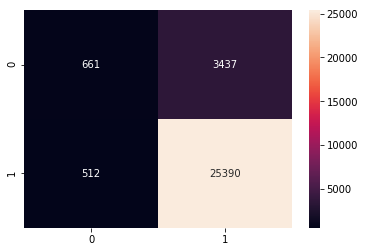

TPR for the model on test data is 0.98
FPR for the model on test data is 0.84
TNR for the model on test data is 0.16
FNR for the model on test data is 0.02



In [34]:
from sklearn.metrics import confusion_matrix
cm_w2v = confusion_matrix(y_test_w2v , y_pred_w2v)
print("Confusion Matrix:")
sns.heatmap(cm_w2v, annot=True, fmt='d')
plt.show()

# calculating TPR, FPR, TNR, FNR

tn, fp, fn, tp = cm_w2v.ravel()

tnr_tf = tn/(tn+fp)
fpr_tf = fp/(tn+fp)
fnr_tf = fn/(fn+tp)
tpr_tf = tp/(fn+tp)

print("TPR for the model on test data is {:.2f}".format(tpr_tf))
print("FPR for the model on test data is {:.2f}".format(fpr_tf))
print("TNR for the model on test data is {:.2f}".format(tnr_tf))
print("FNR for the model on test data is {:.2f}\n".format(fnr_tf))

In [35]:
accuracy_w2v = accuracy_score(y_test_w2v , y_pred_w2v)
precision_w2v = precision_score(y_test_w2v , y_pred_w2v)
recall_w2v = recall_score(y_test_w2v , y_pred_w2v)
f1_w2v = f1_score(y_test_w2v , y_pred_w2v)

print("Accuracy score for the model on test data is {:.2f}".format(accuracy_w2v))
print("Precision score for the model on test data is {:.2f}".format(precision_w2v))
print("Recall score for the model on test data is {:.2f}".format(recall_w2v))
print("F1 score for the model on test data is {:.2f}\n".format(f1_w2v))

Accuracy score for the model on test data is 0.87
Precision score for the model on test data is 0.88
Recall score for the model on test data is 0.98
F1 score for the model on test data is 0.93



# Conclusions

1. Optimal depth was found to be 6 for average Word2Vec and 7 for weighted Word2Vec
2. Both models performed almost similar